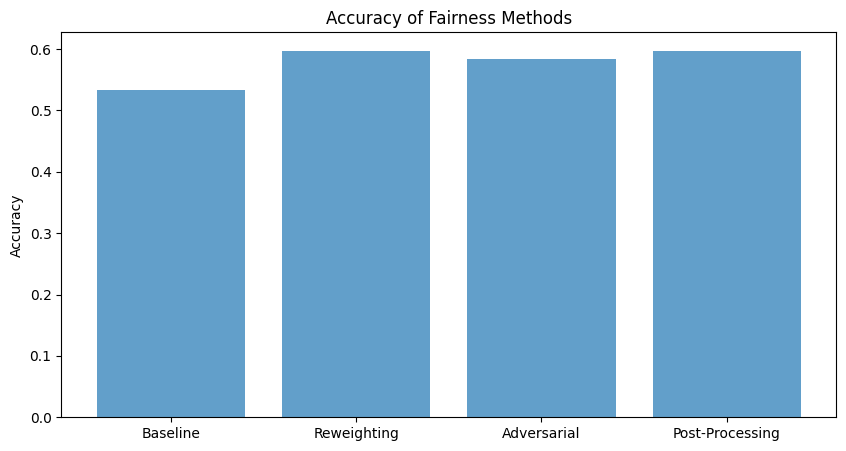

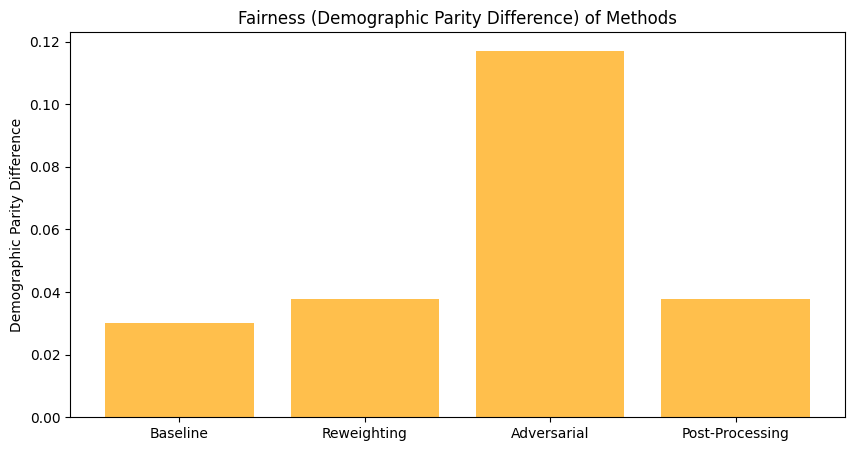

Metrics Summary:
Baseline: Accuracy = 0.5325, Demographic Parity Difference = 0.0302
Reweighting: Accuracy = 0.5974, Demographic Parity Difference = 0.0379
Adversarial: Accuracy = 0.5844, Demographic Parity Difference = 0.1171
Post-Processing: Accuracy = 0.5974, Demographic Parity Difference = 0.0379


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
data = pd.read_csv("preprocessed_data.csv")

# Define predictors and target
features = ['Rating_IMDB_actor', 'Rating_rtaudience_actor', 'Rating_rtcritic_actor',
            'budget', 'revenue', 'Female_actor']
target = 'Winner_film'

X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build and train baseline logistic regression model
baseline_model = LogisticRegression(random_state=42, max_iter=500)
baseline_model.fit(X_train, y_train)

# Predict and evaluate the baseline model
y_pred = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)

# Group predictions by sensitive attribute
sensitive_feature = X_test['Female_actor']
female_group = sensitive_feature == 1
male_group = sensitive_feature == 0

# Calculate fairness metrics for baseline
female_positive_rate = y_pred[female_group].mean() if female_group.any() else 0
male_positive_rate = y_pred[male_group].mean() if male_group.any() else 0
demographic_parity_diff = abs(female_positive_rate - male_positive_rate)
disparate_impact_ratio = (
    female_positive_rate / male_positive_rate if male_positive_rate > 0 else None
)

# Fairness Preprocessing: Reweighting
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
reweighted_model = LogisticRegression(random_state=42, max_iter=500)
reweighted_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_rw = reweighted_model.predict(X_test)

# Fairness In-Processing: Adversarial Debiasing
adjusted_weights = compute_sample_weight("balanced", y=X_train['Female_actor'])
adversarial_model = LogisticRegression(random_state=42, max_iter=500)
adversarial_model.fit(X_train, y_train, sample_weight=adjusted_weights)
y_pred_ad = adversarial_model.predict(X_test)

# Post-Processing: Adjust predictions
def post_processing(predictions, sensitive_feature):
    thresholds = {0: 0.5, 1: 0.5}  # Thresholds for male and female groups
    pred_adj = predictions.copy()
    pred_adj[sensitive_feature == 0] = (predictions[sensitive_feature == 0] > thresholds[0]).astype(int)
    pred_adj[sensitive_feature == 1] = (predictions[sensitive_feature == 1] > thresholds[1]).astype(int)
    return pred_adj

y_pred_pp = post_processing(y_pred_rw, sensitive_feature)

# Evaluate metrics for all models
metrics = {
    "Baseline": (accuracy_score(y_test, y_pred), abs(y_pred[female_group].mean() - y_pred[male_group].mean())),
    "Reweighting": (accuracy_score(y_test, y_pred_rw), abs(y_pred_rw[female_group].mean() - y_pred_rw[male_group].mean())),
    "Adversarial": (accuracy_score(y_test, y_pred_ad), abs(y_pred_ad[female_group].mean() - y_pred_ad[male_group].mean())),
    "Post-Processing": (accuracy_score(y_test, y_pred_pp), abs(y_pred_pp[female_group].mean() - y_pred_pp[male_group].mean()))
}

# Visualize results
accuracy_values = [v[0] for v in metrics.values()]
fairness_values = [v[1] for v in metrics.values()]
methods = list(metrics.keys())

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.bar(methods, accuracy_values, alpha=0.7)
plt.title("Accuracy of Fairness Methods")
plt.ylabel("Accuracy")
plt.show()

# Plot fairness
plt.figure(figsize=(10, 5))
plt.bar(methods, fairness_values, alpha=0.7, color='orange')
plt.title("Fairness (Demographic Parity Difference) of Methods")
plt.ylabel("Demographic Parity Difference")
plt.show()

# Output metrics
print("Metrics Summary:")
for method, (accuracy, fairness) in metrics.items():
    print(f"{method}: Accuracy = {accuracy:.4f}, Demographic Parity Difference = {fairness:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


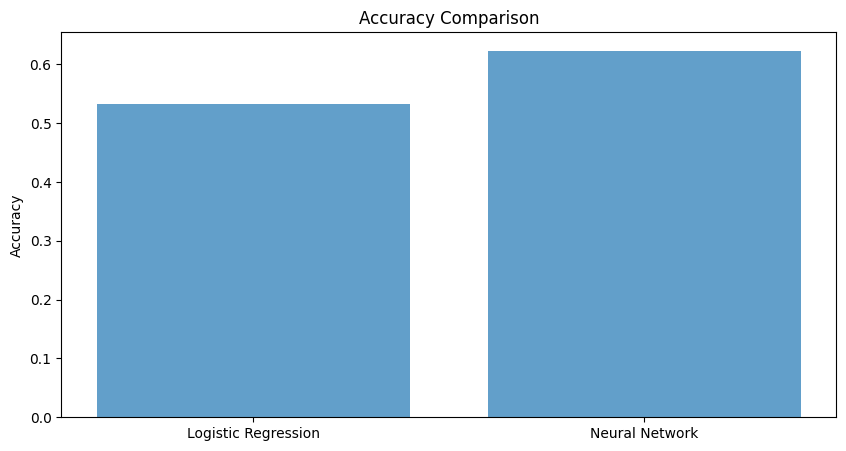

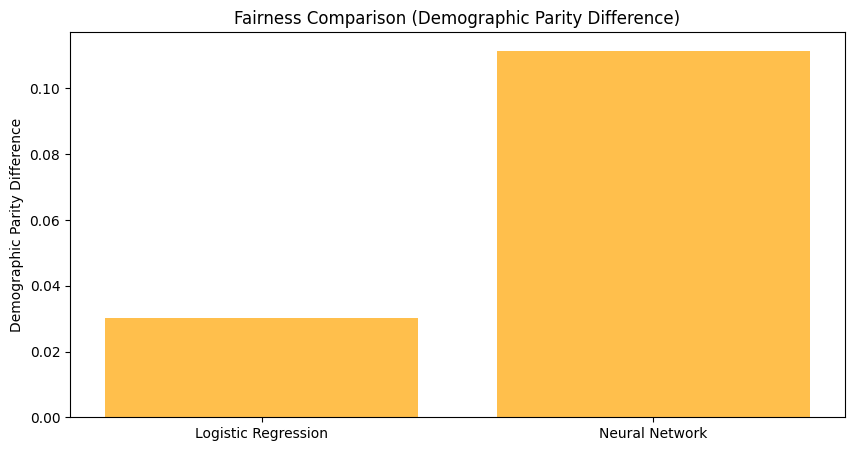

Metrics Summary:
Logistic Regression: Accuracy = 0.5325, Demographic Parity Difference = 0.0302
Neural Network: Accuracy = 0.6234, Demographic Parity Difference = 0.1115


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load dataset
data = pd.read_csv("preprocessed_data.csv")

# Define predictors and target
features = ['Rating_IMDB_actor', 'Rating_rtaudience_actor', 'Rating_rtcritic_actor',
            'budget', 'revenue', 'Female_actor']
target = 'Winner_film'

X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build and train baseline logistic regression model
baseline_model = LogisticRegression(random_state=42, max_iter=500)
baseline_model.fit(X_train, y_train)

# Predict and evaluate the baseline model
y_pred_lr = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_lr)

# Group predictions by sensitive attribute
sensitive_feature = X_test['Female_actor']
female_group = sensitive_feature == 1
male_group = sensitive_feature == 0

# Calculate fairness metrics for baseline
female_positive_rate = y_pred_lr[female_group].mean() if female_group.any() else 0
male_positive_rate = y_pred_lr[male_group].mean() if male_group.any() else 0
demographic_parity_diff_lr = abs(female_positive_rate - male_positive_rate)

# Neural Network Implementation
nn_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train Neural Network
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predict and evaluate the Neural Network
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
nn_accuracy = accuracy_score(y_test, y_pred_nn)

# Calculate fairness metrics for Neural Network
female_positive_rate_nn = y_pred_nn[female_group].mean() if female_group.any() else 0
male_positive_rate_nn = y_pred_nn[male_group].mean() if male_group.any() else 0
demographic_parity_diff_nn = abs(female_positive_rate_nn - male_positive_rate_nn)

# Collect metrics for comparison
metrics = {
    "Logistic Regression": (baseline_accuracy, demographic_parity_diff_lr),
    "Neural Network": (nn_accuracy, demographic_parity_diff_nn)
}

# Visualize results
accuracy_values = [v[0] for v in metrics.values()]
fairness_values = [v[1] for v in metrics.values()]
methods = list(metrics.keys())

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.bar(methods, accuracy_values, alpha=0.7)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# Plot fairness
plt.figure(figsize=(10, 5))
plt.bar(methods, fairness_values, alpha=0.7, color='orange')
plt.title("Fairness Comparison (Demographic Parity Difference)")
plt.ylabel("Demographic Parity Difference")
plt.show()

# Output metrics
print("Metrics Summary:")
for method, (accuracy, fairness) in metrics.items():
    print(f"{method}: Accuracy = {accuracy:.4f}, Demographic Parity Difference = {fairness:.4f}")

In [ ]:
pip install tensorflow


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


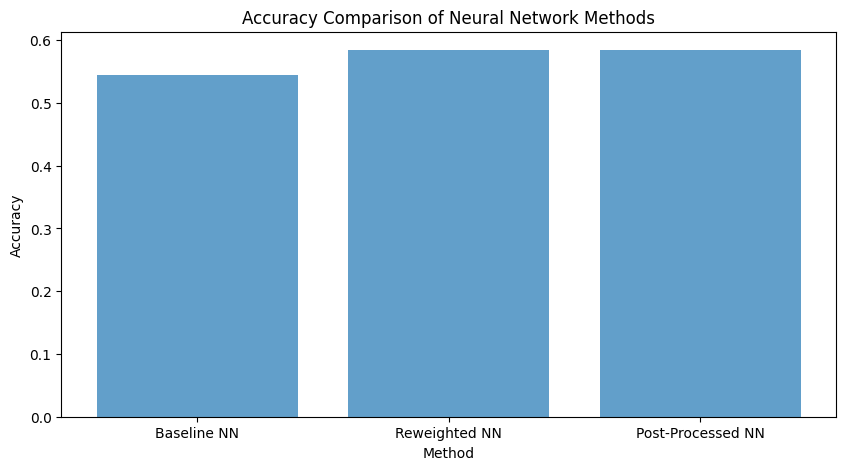

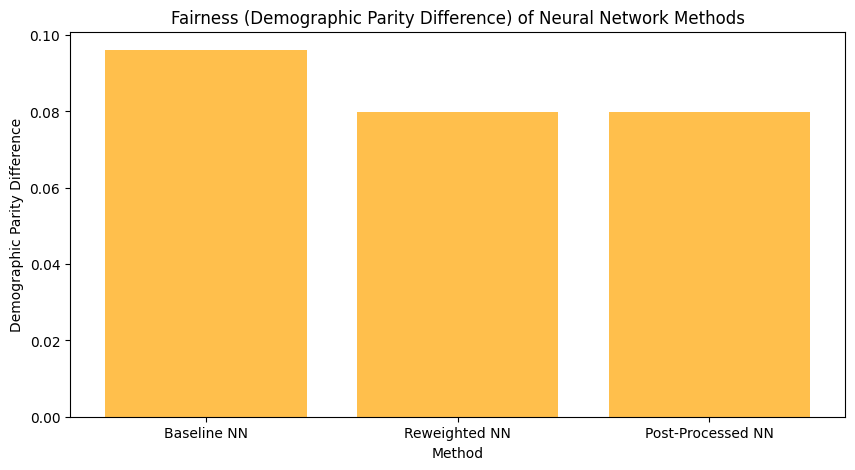

Metrics Summary for Neural Network:
Baseline NN: Accuracy = 0.5455, Demographic Parity Difference = 0.0961
Reweighted NN: Accuracy = 0.5844, Demographic Parity Difference = 0.0799
Post-Processed NN: Accuracy = 0.5844, Demographic Parity Difference = 0.0799


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load dataset
data = pd.read_csv("preprocessed_data.csv")

# Define predictors and target
features = ['Rating_IMDB_actor', 'Rating_rtaudience_actor', 'Rating_rtcritic_actor',
            'budget', 'revenue', 'Female_actor']
target = 'Winner_film'

X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Neural Network Model
nn_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the baseline Neural Network
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predict and evaluate baseline Neural Network
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
nn_accuracy = accuracy_score(y_test, y_pred_nn)

# Fairness metrics for baseline Neural Network
sensitive_feature = X_test['Female_actor']
female_group = sensitive_feature == 1
male_group = sensitive_feature == 0

female_positive_rate_nn = y_pred_nn[female_group].mean() if female_group.any() else 0
male_positive_rate_nn = y_pred_nn[male_group].mean() if male_group.any() else 0
demographic_parity_diff_nn = abs(female_positive_rate_nn - male_positive_rate_nn)

# Reweighting for Neural Network
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

nn_model_rw = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model_rw.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

nn_model_rw.fit(X_train, y_train, sample_weight=sample_weights, epochs=50, batch_size=32, verbose=0)

# Predict and evaluate Reweighted Neural Network
y_pred_rw = (nn_model_rw.predict(X_test) > 0.5).astype(int).flatten()
nn_accuracy_rw = accuracy_score(y_test, y_pred_rw)

# Fairness metrics for Reweighted Neural Network
female_positive_rate_rw = y_pred_rw[female_group].mean() if female_group.any() else 0
male_positive_rate_rw = y_pred_rw[male_group].mean() if male_group.any() else 0
demographic_parity_diff_rw = abs(female_positive_rate_rw - male_positive_rate_rw)

# Post-Processing for Neural Network
def post_processing(predictions, sensitive_feature):
    thresholds = {0: 0.5, 1: 0.5}  # Thresholds for male and female groups
    pred_adj = predictions.copy()
    pred_adj[sensitive_feature == 0] = (predictions[sensitive_feature == 0] > thresholds[0]).astype(int)
    pred_adj[sensitive_feature == 1] = (predictions[sensitive_feature == 1] > thresholds[1]).astype(int)
    return pred_adj

y_pred_pp = post_processing(y_pred_rw, sensitive_feature)
nn_accuracy_pp = accuracy_score(y_test, y_pred_pp)

# Fairness metrics for Post-Processed Neural Network
female_positive_rate_pp = y_pred_pp[female_group].mean() if female_group.any() else 0
male_positive_rate_pp = y_pred_pp[male_group].mean() if male_group.any() else 0
demographic_parity_diff_pp = abs(female_positive_rate_pp - male_positive_rate_pp)

# Prepare metrics for Neural Network methods
metrics_nn = {
    "Baseline NN": (nn_accuracy, demographic_parity_diff_nn),
    "Reweighted NN": (nn_accuracy_rw, demographic_parity_diff_rw),
    "Post-Processed NN": (nn_accuracy_pp, demographic_parity_diff_pp),
}

# Extract accuracy and fairness values
accuracy_values_nn = [v[0] for v in metrics_nn.values()]
fairness_values_nn = [v[1] for v in metrics_nn.values()]
methods_nn = list(metrics_nn.keys())

# Accuracy Graph for Neural Network Methods
plt.figure(figsize=(10, 5))
plt.bar(methods_nn, accuracy_values_nn, alpha=0.7)
plt.title("Accuracy Comparison of Neural Network Methods")
plt.ylabel("Accuracy")
plt.xlabel("Method")
plt.show()

# Fairness Graph for Neural Network Methods
plt.figure(figsize=(10, 5))
plt.bar(methods_nn, fairness_values_nn, alpha=0.7, color='orange')
plt.title("Fairness (Demographic Parity Difference) of Neural Network Methods")
plt.ylabel("Demographic Parity Difference")
plt.xlabel("Method")
plt.show()

# Output metrics
print("Metrics Summary for Neural Network:")
for method, (accuracy, fairness) in metrics_nn.items():
    print(f"{method}: Accuracy = {accuracy:.4f}, Demographic Parity Difference = {fairness:.4f}")

Privacy

<ipython-input-14-6654233063cf>:57: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


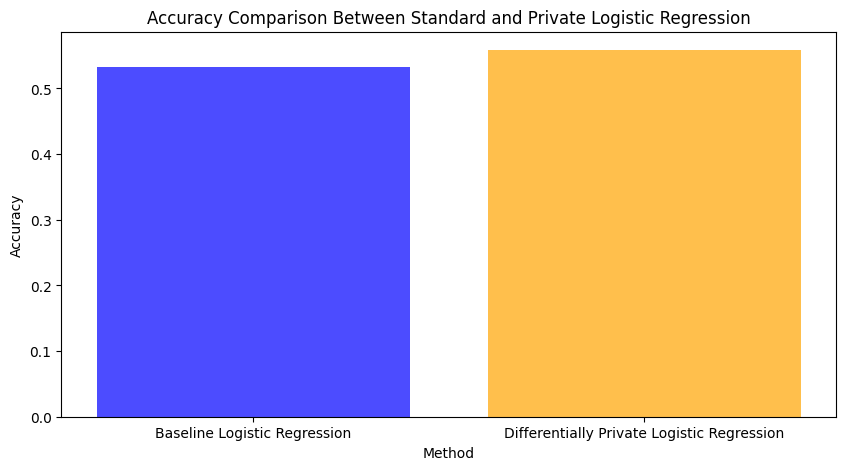

Privacy Metrics Summary:
Baseline Logistic Regression: Accuracy = 0.5325
Differentially Private Logistic Regression: Accuracy = 0.5584


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import numpy as np

# Load dataset
data = pd.read_csv("preprocessed_data.csv")

# Define predictors and target
features = ['Rating_IMDB_actor', 'Rating_rtaudience_actor', 'Rating_rtcritic_actor',
            'budget', 'revenue', 'Female_actor']
target = 'Winner_film'

X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standard Logistic Regression (Baseline)
baseline_model = LogisticRegression(random_state=42, max_iter=500)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

# Differential Privacy Implementation (Adding Noise to Gradient Updates)
class DifferentiallyPrivateLogisticRegression:
    def __init__(self, epsilon=1.0, alpha=0.01, epochs=100):
        self.epsilon = epsilon  # Privacy parameter
        self.alpha = alpha  # Learning rate
        self.epochs = epochs
        self.weights = None

    def _add_noise(self, gradient):
        noise = np.random.laplace(0, 1/self.epsilon, size=gradient.shape)
        return gradient + noise

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        for epoch in range(self.epochs):
            for i in range(m):
                xi = X[i]
                yi = y[i]
                gradient = (yi - self._sigmoid(np.dot(xi, self.weights))) * xi
                noisy_gradient = self._add_noise(gradient)
                self.weights += self.alpha * noisy_gradient

    def predict(self, X):
        probabilities = self._sigmoid(np.dot(X, self.weights))
        return (probabilities >= 0.5).astype(int)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

# Train Differentially Private Logistic Regression
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()

private_model = DifferentiallyPrivateLogisticRegression(epsilon=0.5, alpha=0.01, epochs=100)
private_model.fit(X_train_np, y_train_np)
y_pred_private = private_model.predict(X_test_np)
accuracy_private = accuracy_score(y_test, y_pred_private)

# Compare Results
methods = ["Baseline Logistic Regression", "Differentially Private Logistic Regression"]
accuracies = [accuracy_baseline, accuracy_private]

# Accuracy Graph
plt.figure(figsize=(10, 5))
plt.bar(methods, accuracies, alpha=0.7, color=['blue', 'orange'])
plt.title("Accuracy Comparison Between Standard and Private Logistic Regression")
plt.ylabel("Accuracy")
plt.xlabel("Method")
plt.show()

# Output Metrics
print("Privacy Metrics Summary:")
print(f"Baseline Logistic Regression: Accuracy = {accuracy_baseline:.4f}")
print(f"Differentially Private Logistic Regression: Accuracy = {accuracy_private:.4f}")

<ipython-input-15-2cd72634dc92>:58: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-15-2cd72634dc92>:58: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-15-2cd72634dc92>:58: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-15-2cd72634dc92>:58: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-15-2cd72634dc92>:58: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


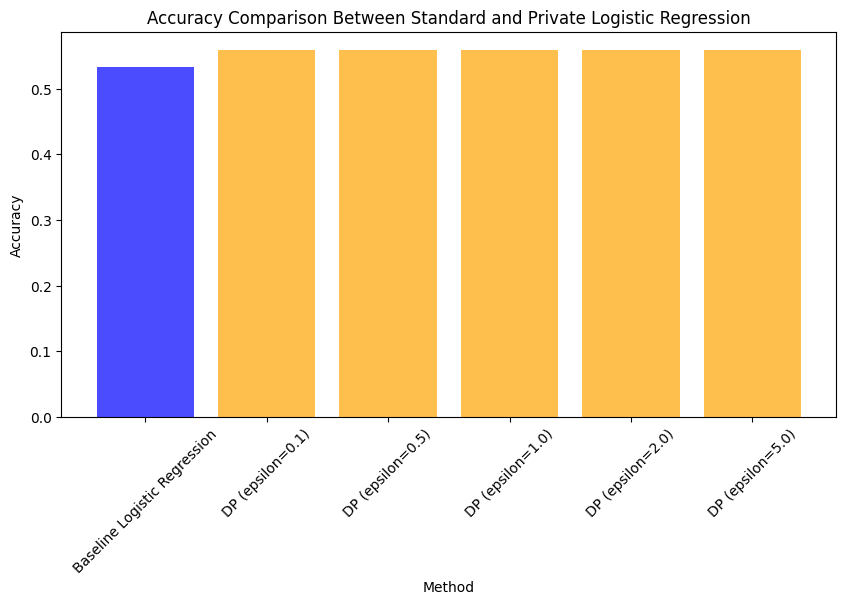

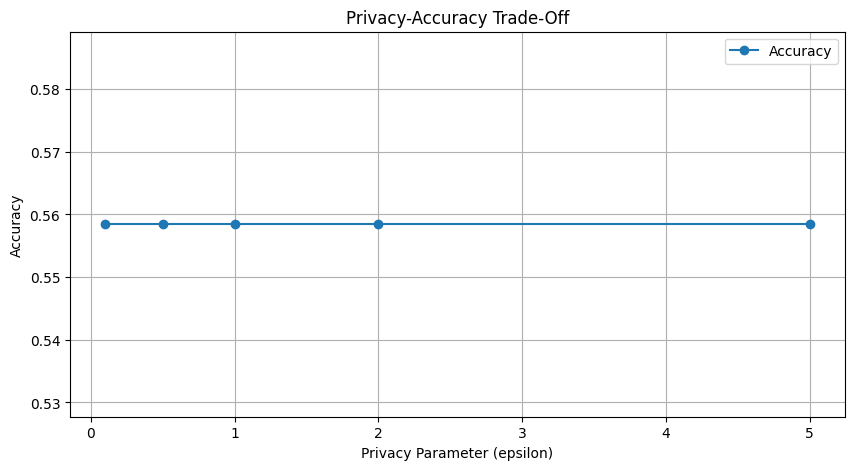

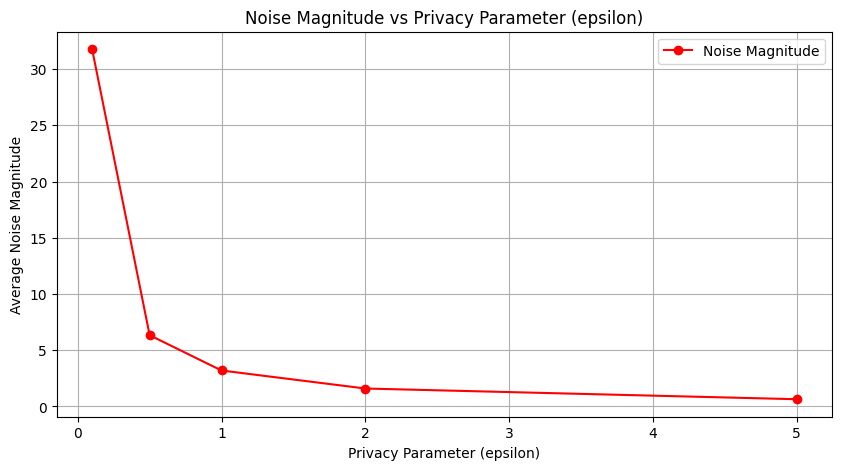

Privacy Metrics Summary:
Baseline Logistic Regression: Accuracy = 0.5325
Differentially Private Logistic Regression (epsilon=0.1): Accuracy = 0.5584, Avg Noise Magnitude = 31.7682
Differentially Private Logistic Regression (epsilon=0.5): Accuracy = 0.5584, Avg Noise Magnitude = 6.3311
Differentially Private Logistic Regression (epsilon=1.0): Accuracy = 0.5584, Avg Noise Magnitude = 3.1935
Differentially Private Logistic Regression (epsilon=2.0): Accuracy = 0.5584, Avg Noise Magnitude = 1.5914
Differentially Private Logistic Regression (epsilon=5.0): Accuracy = 0.5584, Avg Noise Magnitude = 0.6388


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
data = pd.read_csv("preprocessed_data.csv")

# Define predictors and target
features = ['Rating_IMDB_actor', 'Rating_rtaudience_actor', 'Rating_rtcritic_actor',
            'budget', 'revenue', 'Female_actor']
target = 'Winner_film'

X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standard Logistic Regression (Baseline)
baseline_model = LogisticRegression(random_state=42, max_iter=500)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

# Differential Privacy Implementation (Adding Noise to Gradient Updates)
class DifferentiallyPrivateLogisticRegression:
    def __init__(self, epsilon=1.0, alpha=0.01, epochs=100):
        self.epsilon = epsilon  # Privacy parameter
        self.alpha = alpha  # Learning rate
        self.epochs = epochs
        self.weights = None
        self.noise_magnitudes = []

    def _add_noise(self, gradient):
        noise = np.random.laplace(0, 1/self.epsilon, size=gradient.shape)
        self.noise_magnitudes.append(np.linalg.norm(noise))  # Track noise magnitude
        return gradient + noise

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        for epoch in range(self.epochs):
            for i in range(m):
                xi = X[i]
                yi = y[i]
                gradient = (yi - self._sigmoid(np.dot(xi, self.weights))) * xi
                noisy_gradient = self._add_noise(gradient)
                self.weights += self.alpha * noisy_gradient

    def predict(self, X):
        probabilities = self._sigmoid(np.dot(X, self.weights))
        return (probabilities >= 0.5).astype(int)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

# Train Differentially Private Logistic Regression
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()

privacy_epsilons = [0.1, 0.5, 1.0, 2.0, 5.0]
accuracy_private_models = []
noise_magnitudes_per_epsilon = []

for epsilon in privacy_epsilons:
    private_model = DifferentiallyPrivateLogisticRegression(epsilon=epsilon, alpha=0.01, epochs=100)
    private_model.fit(X_train_np, y_train_np)
    y_pred_private = private_model.predict(X_test_np)
    accuracy_private = accuracy_score(y_test, y_pred_private)
    accuracy_private_models.append(accuracy_private)
    noise_magnitudes_per_epsilon.append(np.mean(private_model.noise_magnitudes))

# Compare Results
methods = ["Baseline Logistic Regression"] + [f"DP (epsilon={eps})" for eps in privacy_epsilons]
accuracies = [accuracy_baseline] + accuracy_private_models

# Accuracy Graph
plt.figure(figsize=(10, 5))
plt.bar(methods, accuracies, alpha=0.7, color=['blue'] + ['orange'] * len(privacy_epsilons))
plt.title("Accuracy Comparison Between Standard and Private Logistic Regression")
plt.ylabel("Accuracy")
plt.xlabel("Method")
plt.xticks(rotation=45)
plt.show()

# Privacy-Accuracy Trade-Off
plt.figure(figsize=(10, 5))
plt.plot(privacy_epsilons, accuracy_private_models, marker='o', label='Accuracy')
plt.title("Privacy-Accuracy Trade-Off")
plt.xlabel("Privacy Parameter (epsilon)")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

# Noise Magnitude Graph
plt.figure(figsize=(10, 5))
plt.plot(privacy_epsilons, noise_magnitudes_per_epsilon, marker='o', color='red', label='Noise Magnitude')
plt.title("Noise Magnitude vs Privacy Parameter (epsilon)")
plt.xlabel("Privacy Parameter (epsilon)")
plt.ylabel("Average Noise Magnitude")
plt.grid()
plt.legend()
plt.show()

# Output Metrics
print("Privacy Metrics Summary:")
print(f"Baseline Logistic Regression: Accuracy = {accuracy_baseline:.4f}")
for eps, acc, noise in zip(privacy_epsilons, accuracy_private_models, noise_magnitudes_per_epsilon):
    print(f"Differentially Private Logistic Regression (epsilon={eps}): Accuracy = {acc:.4f}, Avg Noise Magnitude = {noise:.4f}")


<ipython-input-16-3a3ff7d2a2bc>:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-16-3a3ff7d2a2bc>:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-16-3a3ff7d2a2bc>:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-16-3a3ff7d2a2bc>:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-16-3a3ff7d2a2bc>:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-16-3a3ff7d2a2bc>:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-16-3a3ff7d2a2bc>:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


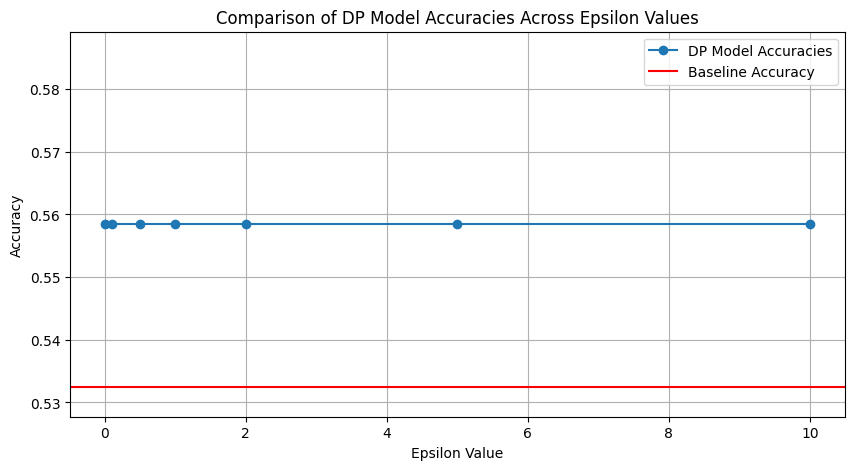

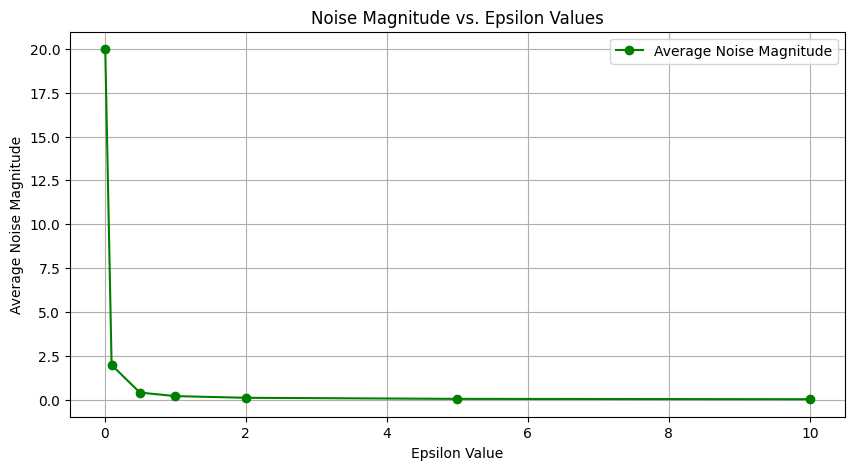

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Load dataset
data = pd.read_csv("preprocessed_data.csv")

# Define predictors and target
features = ['Rating_IMDB_actor', 'Rating_rtaudience_actor', 'Rating_rtcritic_actor', 'budget', 'revenue', 'Female_actor']
target = 'Winner_film'

X = data[features].values
y = data[target].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standard Logistic Regression (Baseline)
baseline_model = LogisticRegression(random_state=42, max_iter=500)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

# Differentially Private Logistic Regression Implementation
class DifferentiallyPrivateLogisticRegression:
    def __init__(self, epsilon=1.0, alpha=0.01, epochs=100, batch_size=32):
        self.epsilon = epsilon
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = None
        self.noise_magnitudes = []

    def _add_noise(self, gradient, sensitivity):
        scale = sensitivity / self.epsilon
        noise = np.random.laplace(0, scale, size=gradient.shape)
        self.noise_magnitudes.append(np.linalg.norm(noise))  # Store the magnitude of the noise
        return gradient + noise

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.noise_magnitudes.clear()  # Clear previous noise magnitudes
        for epoch in range(self.epochs):
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                batch_X = X[start:end]
                batch_y = y[start:end]
                predictions = self._sigmoid(np.dot(batch_X, self.weights))
                gradient = np.dot(batch_X.T, (predictions - batch_y)) / self.batch_size
                sensitivity = 2.0 / self.batch_size
                noisy_gradient = self._add_noise(gradient, sensitivity)
                self.weights -= self.alpha * noisy_gradient
        average_noise = np.mean(self.noise_magnitudes)  # Average noise magnitude per run
        return average_noise

    def predict(self, X):
        probabilities = self._sigmoid(np.dot(X, self.weights))
        return (probabilities >= 0.5).astype(int)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

# Define a range of epsilon values to test
epsilon_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
dp_accuracies = []
noise_magnitudes = []

# Train and evaluate models for each epsilon value
for epsilon in epsilon_values:
    dp_model = DifferentiallyPrivateLogisticRegression(epsilon=epsilon, alpha=0.01, epochs=100, batch_size=32)
    average_noise = dp_model.fit(X_train, y_train)
    y_pred_dp = dp_model.predict(X_test)
    dp_accuracy = accuracy_score(y_test, y_pred_dp)
    dp_accuracies.append(dp_accuracy)
    noise_magnitudes.append(average_noise)

# Plot comparison of accuracies and noise magnitudes
plt.figure(figsize=(10, 5))
plt.plot(epsilon_values, dp_accuracies, marker='o', label='DP Model Accuracies')
plt.axhline(y=accuracy_baseline, color='r', linestyle='-', label='Baseline Accuracy')
plt.title("Comparison of DP Model Accuracies Across Epsilon Values")
plt.xlabel("Epsilon Value")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epsilon_values, noise_magnitudes, marker='o', color='green', label='Average Noise Magnitude')
plt.title("Noise Magnitude vs. Epsilon Values")
plt.xlabel("Epsilon Value")
plt.ylabel("Average Noise Magnitude")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-17-d1b6a6d0232b>:60: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-17-d1b6a6d0232b>:60: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-17-d1b6a6d0232b>:60: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-17-d1b6a6d0232b>:60: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-17-d1b6a6d0232b>:60: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-17-d1b6a6d0232b>:60: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-17-d1b6a6d0232b>:60: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epsilon: 0.01, DP Model Accuracy: 0.5584, Baseline Accuracy: 0.5325, Difference: 0.0260
Epsilon: 0.1, DP Model Accuracy: 0.5584, Baseline Accuracy: 0.5325, Difference: 0.0260
Epsilon: 0.5, DP Model Accuracy: 0.5584, Baseline Accuracy: 0.5325, Difference: 0.0260
Epsilon: 1.0, DP Model Accuracy: 0.5584, Baseline Accuracy: 0.5325, Difference: 0.0260
Epsilon: 2.0, DP Model Accuracy: 0.5584, Baseline Accuracy: 0.5325, Difference: 0.0260
Epsilon: 5.0, DP Model Accuracy: 0.5584, Baseline Accuracy: 0.5325, Difference: 0.0260
Epsilon: 10.0, DP Model Accuracy: 0.5584, Baseline Accuracy: 0.5325, Difference: 0.0260


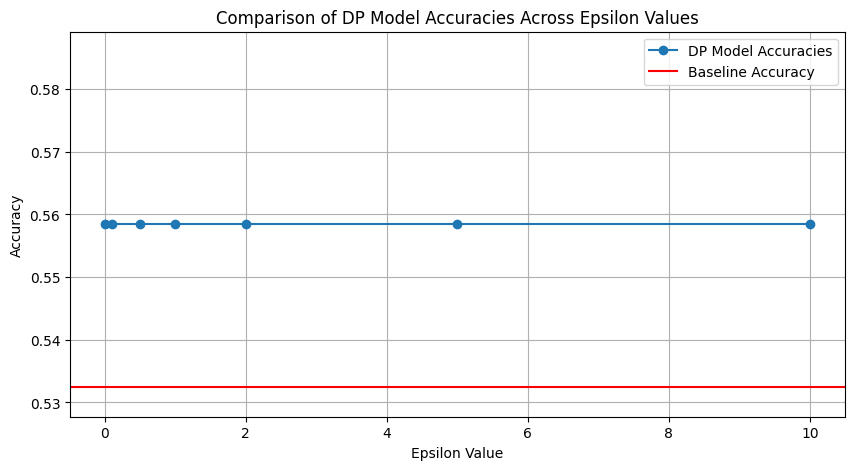

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Load dataset
data = pd.read_csv("preprocessed_data.csv")

# Define predictors and target
features = ['Rating_IMDB_actor', 'Rating_rtaudience_actor', 'Rating_rtcritic_actor', 'budget', 'revenue', 'Female_actor']
target = 'Winner_film'

X = data[features].values
y = data[target].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standard Logistic Regression (Baseline)
baseline_model = LogisticRegression(random_state=42, max_iter=500)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

# Differentially Private Logistic Regression Implementation
class DifferentiallyPrivateLogisticRegression:
    def __init__(self, epsilon=1.0, alpha=0.01, epochs=100, batch_size=32):
        self.epsilon = epsilon  # Privacy parameter
        self.alpha = alpha  # Learning rate
        self.epochs = epochs
        self.batch_size = batch_size  # Batch size for updates
        self.weights = None

    def _add_noise(self, gradient, sensitivity):
        scale = sensitivity / self.epsilon
        noise = np.random.laplace(0, scale, size=gradient.shape)
        return gradient + noise

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        for epoch in range(self.epochs):
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                batch_X = X[start:end]
                batch_y = y[start:end]
                predictions = self._sigmoid(np.dot(batch_X, self.weights))
                gradient = np.dot(batch_X.T, (predictions - batch_y)) / self.batch_size
                sensitivity = 2.0 / self.batch_size
                noisy_gradient = self._add_noise(gradient, sensitivity)
                self.weights -= self.alpha * noisy_gradient

    def predict(self, X):
        probabilities = self._sigmoid(np.dot(X, self.weights))
        return (probabilities >= 0.5).astype(int)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

# Define a range of epsilon values to test
epsilon_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

# Train and evaluate models for each epsilon value
dp_accuracies = []
for epsilon in epsilon_values:
    dp_model = DifferentiallyPrivateLogisticRegression(epsilon=epsilon, alpha=0.01, epochs=100, batch_size=32)
    dp_model.fit(X_train, y_train)
    y_pred_dp = dp_model.predict(X_test)
    dp_accuracy = accuracy_score(y_test, y_pred_dp)
    dp_accuracies.append(dp_accuracy)
    print(f"Epsilon: {epsilon}, DP Model Accuracy: {dp_accuracy:.4f}, Baseline Accuracy: {accuracy_baseline:.4f}, Difference: {dp_accuracy - accuracy_baseline:.4f}")

# Plot comparison of accuracies
plt.figure(figsize=(10, 5))
plt.plot(epsilon_values, dp_accuracies, marker='o', label='DP Model Accuracies')
plt.axhline(y=accuracy_baseline, color='r', linestyle='-', label='Baseline Accuracy')
plt.title("Comparison of DP Model Accuracies Across Epsilon Values")
plt.xlabel("Epsilon Value")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv("preprocessed_data.csv")

# Define the required columns
selected_columns = ['Category_actor','Rating_IMDB_actor', 'Rating_rtaudience_actor', 'Rating_rtcritic_actor', 'budget', 'revenue', 'Female_actor']

# Check if all columns exist in the dataset
if all(col in data.columns for col in selected_columns):
    # Select only the required columns
    selected_data = data[selected_columns]

    # Sort the dataset by one of the columns (e.g., 'budget')
    sorted_data = selected_data.sort_values(by='budget', ascending=False)

    # Save the sorted data to a new CSV file
    sorted_data.to_csv("sorted_data.csv", index=False)
    print("Sorted data saved as 'sorted_data.csv'")
else:
    missing_columns = [col for col in selected_columns if col not in data.columns]
    print(f"The following columns are missing from the dataset: {missing_columns}")


Sorted data saved as 'sorted_data.csv'
